In [1]:
# import the packages
import numpy as np
from scipy.io import loadmat
import cvxpy as cp

In [2]:
# -----------------------------------------------------------
# Step 1: Preprocessing (normalize to [-1,1])
# -----------------------------------------------------------
def normalize_signal(x):
    xmax = np.max(x[x > 0]) if np.any(x > 0) else 1
    xmin = np.min(x[x < 0]) if np.any(x < 0) else -1
    x_norm = np.zeros_like(x, dtype=float)

    x_norm[x > 0] = x[x > 0] / xmax
    x_norm[x < 0] = x[x < 0] / abs(xmin)

    return x_norm

In [10]:
# -----------------------------------------------------------
# Step 2: Sparse Linear Prediction (simplified AR coeffs)
# -----------------------------------------------------------
def slp_coefficients(y, K=20, gamma_range=np.logspace(-2, 2, 40)):
    """
    Sparse Linear Prediction with optimal gamma selection (Annex F.1.2).
    
    Args:
        x : 1D numpy array (input vibrotactile frame)
        K : int, prediction order
        gamma_range : array-like, values of gamma to try
    
    Returns:
        a_opt : numpy array, optimal SLP coefficients
        gamma_opt : float, selected gamma value
        coeff_norms : list of ||a||_1 values for each gamma
        residual_norms : list of ||x - Xa||_1 values for each gamma
    """
    N = len(y)
    # Construct regression matrix
    Y = np.zeros((N - K, K))
    y_target = y[K:]  # The values to predict
    
    for i in range(K):
        Y[:, i] = y[K - i - 1:N - i - 1]  # Shifted past samples

    residual_norms = []
    coeff_norms = []
    residuals = []
    coefficients = []

    # Sweep gamma values
    for gamma in gamma_range:

        m, n = Y.shape
    
        # Variables
        a = cp.Variable(n)
        u = cp.Variable(m)  # residuals
        v = cp.Variable(n)  # for |a|
    
        # Constraints to represent L1 norms
        constraints = [
            Y @ a - y_target <= u,
            y_target - Y @ a <= u,
            a <= v,
            -a <= v,
            u >= 0,
            v >= 0
        ]
    
        # Objective
        objective = cp.Minimize(cp.sum(u) + gamma * cp.sum(v))
    
        # Problem
        prob = cp.Problem(objective, constraints)
        prob.solve(solver=cp.SCS)  # You can also try cp.SCS

        r = y_target - Y @ a.value
        residual_norms.append(np.linalg.norm(r, 1))
        coeff_norms.append(np.linalg.norm(a.value, 1))
        residuals.append(r)
        coefficients.append(a.value)

    residual_norms = np.array(residual_norms)
    coeff_norms = np.array(coeff_norms)

    return residual_norms, coeff_norms, residuals, coefficients

In [23]:
# -----------------------------------------------------------
# Example Run
# -----------------------------------------------------------
if __name__ == "__main__":

    tooltip = "1spike_Probe" # 1spike_Probe, 3x1small-round_Probe, 3x1spike_Probe, 3x3_Probe, 3x3small-round_Probe, big-half-round_Probe, big-round_Probe, finger_Probe
    material = "polyesterPad"  # BalticBrown, aluminiumGrid, antiVibPad, bamboo, cork, felt, foam, polyesterPad, rubber
    speed = "fast"  # medium, fast
    sampling_rate = 2800
    dct_quantization_scale = 1.0
    num_samples_per_frame = 200
    ar_order = 20

    acc_samples_filename = "./signal_trace_data/Direct_-_" + tooltip + "_-_" + material + "_-_" + speed + ".mat"

    data = loadmat(acc_samples_filename)
    material_samples = data["material"]

    acc_combined_cut = material_samples["joinedAccPaperCut"][0,0]
    acc_combined_cut = np.asarray(acc_combined_cut).flatten()

    acc_combined_cut_frame = acc_combined_cut[0:num_samples_per_frame]

    # Step 1: Normalize
    x_norm = normalize_signal(acc_combined_cut_frame)

    # Step 2: SLP coefficients
    residual_norms, coeff_norms, residuals, coefficients = slp_coefficients(x_norm, K=ar_order)


In [12]:
np.save('residual_norms.npy', residual_norms)
np.save('coeff_norms.npy', coeff_norms)
np.save('residuals.npy', residuals)
np.save('coefficients.npy', coefficients)

In [13]:
residual_norms = np.load('residual_norms.npy')
coeff_norms = np.load('coeff_norms.npy')
residuals = np.load('residuals.npy')
coefficients = np.load('coefficients.npy')

In [24]:
# Find "corner" of the L-curve (max distance to line between endpoints)
gamma_range=np.logspace(-2, 2, 40)
x1, y1 = coeff_norms[0], residual_norms[0]
x2, y2 = coeff_norms[-1], residual_norms[-1]
distances = []
for xi, yi in zip(coeff_norms, residual_norms):
    num = abs((y2-y1)*xi - (x2-x1)*yi + x2*y1 - y2*x1)
    den = np.sqrt((y2-y1)**2 + (x2-x1)**2)
    distances.append(num/den)
best_idx = int(np.argmax(distances))

gamma_opt = gamma_range[best_idx]
best_residual_norm = residual_norms[best_idx]
best_coeff_norm = coeff_norms[best_idx]
best_residual = residuals[best_idx]
best_coefficient = coefficients[best_idx]

<StemContainer object of 3 artists>

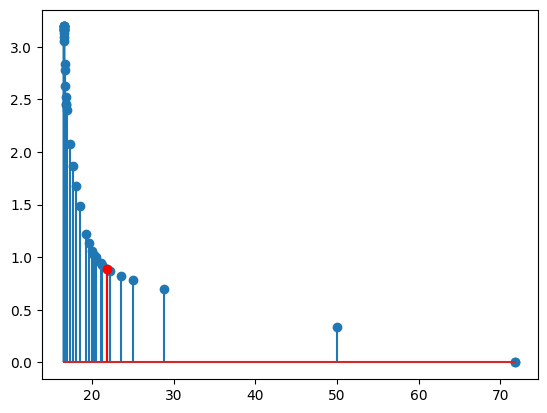

In [26]:
import matplotlib.pyplot as plt

plt.stem(residual_norms, coeff_norms)
plt.stem(best_residual_norm, best_coeff_norm, linefmt='red')

<StemContainer object of 3 artists>

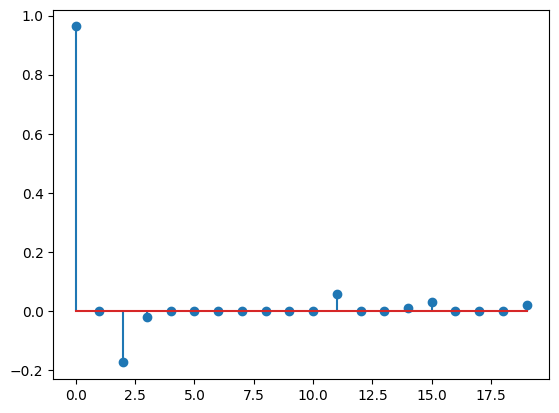

In [21]:
plt.stem(np.arange(ar_order), best_coefficient)

(4097,)


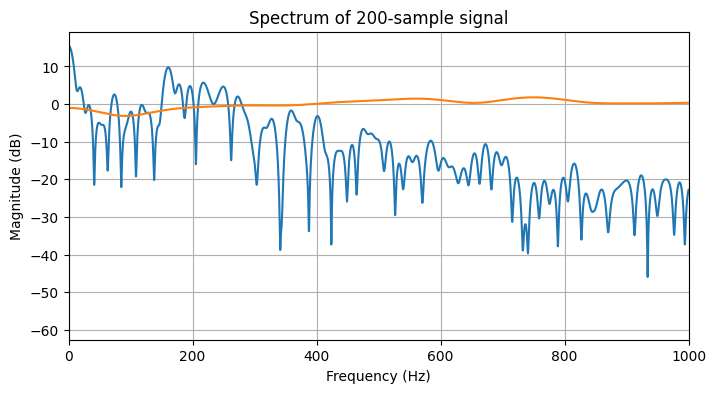

In [20]:
import matplotlib.pyplot as plt

N = len(x_norm)
# Construct regression matrix
Y = np.zeros((N - ar_order, ar_order))
    
for i in range(ar_order):
    Y[:, i] = x_norm[ar_order - i - 1:N - i - 1]  # Shifted past samples

nfft = 8192
fs = 2800
acc_combined_cut_frame_rfft = np.fft.rfft(acc_combined_cut_frame, n=nfft)
freqs = np.fft.rfftfreq(nfft, 1/fs)

mag_db = 20 * np.log10(np.abs(acc_combined_cut_frame_rfft) + 1e-12)

x_tilde = best_coefficient

x_tilde_rfft = np.fft.rfft(x_tilde, n=nfft)  
#R = np.fft.rfft(r)         # FFT
#R_db = 20*np.log10(np.abs(R)+1e-12)
x_tilde_rfft_db = 20*np.log10(np.abs(x_tilde_rfft)+1e-12)

#haha = 20 * np.log10(np.abs(acc_combined_cut_fft) + 1e-12)

print(acc_combined_cut_frame_rfft.shape)
#print(x_tilde_rfft_db.shape)

plt.figure(figsize=(8,4))
plt.plot(freqs, mag_db)
plt.plot(freqs, x_tilde_rfft_db)
plt.xlim(0, 1000)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("Spectrum of 200-sample signal")
plt.grid(True)

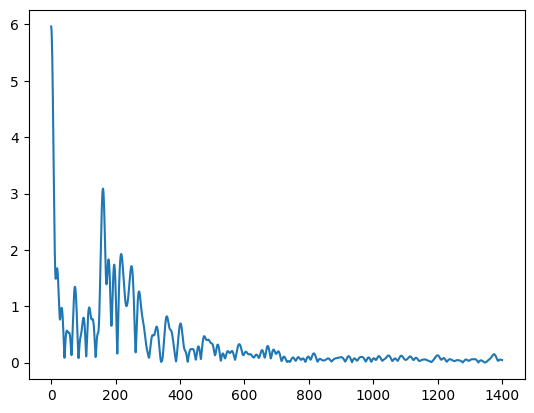

In [22]:
mag = np.abs(acc_combined_cut_frame_rfft)
plt.plot(freqs, mag)